# Running a SUSY grid with mapyde

In this notebook we'll use mapyde to process a SUSY grid (in this case, sleptons) and plot the results.  We use the full mapyde pipeline:

1. MadGraph for event generation
2. Pythia for hadronization
3. Delphes for detector simulation
4. SimpleAnalysis for analysis selection
5. pyhf to fit a public likelihood with the generated signal yields

The input to this is just a set of grid points that will be used to dynamically generate SLHA files (from a template).

In [1]:
import mapyde
from mapyde.runner import run_madgraph, run_delphes, run_ana, run_sa2json, run_simpleanalysis, run_pyhf
from mapyde.utils import build_config, load_config

import os
import toml
import json
import urllib
import glob

import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

If dask is available, set it up.  (Dask is an easy way to parallelize tasks in python.  We use it to process many scan points in parallel.)  If not, no big deal, the jobs will just take a bit longer running serially.

In [2]:
dask_available=False
try:
    import dask
    from dask.distributed import LocalCluster, Client

    cluster = LocalCluster(n_workers=20);
    client = Client(cluster);
    dask_available=True
except ImportError:
    print("Dask is not available, running serially.")

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:41009
INFO:distributed.scheduler:  dashboard at:            127.0.0.1:8787
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43285'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:41519'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38659'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39607'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42971'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33109'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36705'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38057'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40665'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45069'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43613'
INFO:distributed.nanny:        Start Nanny

In [3]:
def get_particle_mass(config,pdg_id):
    SLHAfilename=config["base"]["path"]+"/"+config["base"]["output"]+"/"+config["madgraph"]["params"]+".slha"

    mass=-1
    with open(SLHAfilename,"r") as SLHAfile:
        inmassblock=False
        for line in SLHAfile:
            if "block mass" in line.lower():
                inmassblock=True
                continue
            else:
                if inmassblock:
                    if "Block" in line:
                        inmassblock=False
                        continue
                    sline=line.strip().split()
                    if sline[0]=='#':
                        continue
                    elif int(sline[0])==pdg_id:
                        mass=float(line.strip().split()[1])
                        break
                else:
                    continue
    if mass<0:
        print(f"Could not find particle {pdg_id} mass")

    return mass

This retrieves some ATLAS results that we'll use for plotting at the end.  

In [4]:
expected_contour_mass=[]
expected_contour_splitting=[]
with urllib.request.urlopen('https://www.hepdata.net/download/table/ins1767649/Figure%2016a%20Expected/4/csv') as response:
    for line in response:
        sline=line.decode("utf-8") 
        if sline[0]=='#' or sline[0]=='$': continue
        if len(sline.strip())==0: continue
        expected_contour_mass.append(float(sline.split(',')[0]))
        expected_contour_splitting.append(float(sline.split(',')[1]))
        
observed_contour_mass=[]
observed_contour_splitting=[]
with urllib.request.urlopen('https://www.hepdata.net/download/table/ins1767649/Figure%2016a%20Observed/4/csv') as response:
    for line in response:
        sline=line.decode("utf-8") 
        if sline[0]=='#' or sline[0]=='$': continue
        if len(sline.strip())==0: continue
        observed_contour_mass.append(float(sline.split(',')[0]))
        observed_contour_splitting.append(float(sline.split(',')[1]))

## Setting up the mapyde jobs

These are several helper functions for creating configs or reading existing configs.  (Note we run with MPI turned off in pythia to save time -- for better accuracy, turn it on!)  This is where the information about the SLHA card is injected...  we provide the card under:

```config["base"]["param_path"]/config["madgraph"]["params"].slha```

In [5]:
defaultsusymass=4.5e9

def create_config(MSLEP=100,MN1=99,params="SleptonBino",MN2=defaultsusymass):
    N2tag=""
    if MN2<defaultsusymass:
        N2tag=f"{MN2}_"
    
    return mapyde.utils.build_config(toml.loads(f"""
[base]
path = "/home/jupyter-mhance/mario-mapyde-user/sleptons/SUSY_SleptonBino_isrslep_20220908"
output = "SUSY_SleptonBino_isrslep_{MSLEP}_{N2tag}{MN1}"
template = "{{{{PWD}}}}/templates/sleptons.toml"
process_path = "{{{{PWD}}}}/cards/process/"
param_path = "{{{{PWD}}}}/cards/param/"

[madgraph]
params="{params}"

[madgraph.masses]
MSLEP = {MSLEP}
MN1 = {MN1}
MN2 = {MN2}
MC1 = {MN2}
MSNU = {MN2}

[pythia]
mpi = "off"

[analysis]
kfactor = 1.2
branchingratio = 1.0
"""))

def read_config_json(path,output):
    configfilepath=path+"/"+output+"/configs/"+"config_*"
    configfile=glob.glob(configfilepath)[-1]
    with open(configfile) as cf:
        config=json.load(cf)
    return config   

def read_config_toml(configfile):
    return build_config(load_config(configfile))

def load_results(path,output):
    resultfile=path+"/"+output+"/"+"muscan_results.json"
    with open(resultfile) as rf:
        results=json.load(rf)
    return results

Here we use the mapyde interface to run the jobs.  In this case we're running pMSSM scan points, so the job is defined by the ID of the pMSSM scan point.

In [6]:
def slep_run_pyhf(MSLEP=100,MN1=99,params="SleptonBino",MN2=defaultsusymass,path="",config=None,process="isrslep"):
    if config is not None:
        stdout,stderr,results=run_pyhf(config)
        combined_output={"config": config,
                        "results": results}
        return combined_output
    
    if path=="":
        config=create_config(MSLEP,MN1,params,MN2)
    else:
        if MN2>=defaultsusymass:
            config=read_config_json(path,f"SUSY_{params}_{process}_{MSLEP}_{MN1}")
        else:
            config=read_config_json(path,f"SUSY_{params}_{process}_{MSLEP}_{MN2}_{MN1}")

    stdout,stderr,results=run_pyhf(config)
    combined_output={"config": config,
                    "results": results}
    return combined_output

def slep_run_all(MSLEP=100,MN1=99,params="SleptonBino",MN2=defaultsusymass,config=None):
    if config==None:
        config=create_config(MSLEP,MN1,params,MN2)
    run_madgraph(config)
    run_delphes(config)
    run_ana(config)
    run_simpleanalysis(config)
    run_sa2json(config)
    if not config["pyhf"]["skip"]:
        combined_output=slep_run_pyhf(config)
        return combined_output
    return config

def slep_read_results(MSLEP,MN1,params="SleptonBino",MN2=defaultsusymass,path="sleptons",process="isrslep"):
    config=None
    if MN2>=defaultsusymass:
        outputarea=f"SUSY_{params}_{process}_{MSLEP}_{MN1}"
    else:
        outputarea=f"SUSY_{params}_{process}_{MSLEP}_{MN2}_{MN1}"
    config=read_config_json(path,outputarea)
    results=load_results(path,outputarea)
    combined_output={"config": config,
                    "results": results}
    return combined_output

## Running the SleptonBino jobs

Now run all the points we have.  Can choose whether to run the full thing (from SLHA to limits) or just read results that have already been generated.  If dask is enabled it will run as many processes in parallel as it's allowed.

In [23]:
sleptonbino_output=[]
for m_slep in [100,150,200,250]:
    for dM in [0.5,1,2,3,5,8,10,15,20,30,50]:
        if dask_available:
            # here we load some existing results, in case all we want to do is tweak plots downstream
            sleptonbino_output.append(dask.delayed(slep_read_results)(m_slep,m_slep-dM,path="sleptons/SUSY_SleptonBino_isrslep_20220908"))
            # ...or we can just re-run pyhf
            #sleptonbino_output.append(dask.delayed(slep_run_pyhf)(m_slep,m_slep-dM))
            # ...or we can run the whole thing, generating events from scratch with madgraph
            #sleptonbino_output.append(dask.delayed(slep_run_all)(4305333))
        else:
            # here we load some existing results, in case all we want to do is tweak plots downstream
            sleptonbino_output.append(slep_read_results(m_slep,m_slep-dM,path="sleptons/SUSY_SleptonBino_isrslep_20220908"))
            # ...or we can just re-run pyhf
            #sleptonbino_output.append(slep_run_pyhf(m_slep,m_slep-dM))
            # ...or we can run the whole thing, generating events from scratch with madgraph
            #sleptonbino_output.append(slep_run_all(4305333))
             
        
print(len(sleptonbino_output))
result=None
# if we're running dask, then the commands above will only schedule things to run, not run them.
if dask_available:
    result=dask.compute(sleptonbino_output)
else:
    result=sleptonbino_output

INFO:distributed.core:Event loop was unresponsive in Nanny for 3.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

44


INFO:distributed.core:Event loop was unresponsive in Nanny for 3.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

2023-03-10 15:20:43,582 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
INFO:distributed.nanny:Worker process 1174291 was killed by signal 9
INFO:distributed.nanny:Worker process 1174342 was killed by signal 9
2023-03-10 15:20:43,619 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2023-03-10 15:20:43,630 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing
INFO:distributed.nanny:Worker process 1174325 was killed by signal 9
INFO:distributed.nanny:Worker process 1174295 was killed by signal 9
2023-03-10 15:20:43,663 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2023-03-10 15:20:43,669 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2023-03-10 15:20:43,690 - distributed.nanny - WARNING - Worker process still alive after 3.199999237

Observed limit: 0.5031841559538257
Expected limit: 0.463
      -1 sigma: 0.306
      +1 sigma: 0.636
      -2 sigma: 0.281
      +2 sigma: 0.862
Observed limit: 2.0
Expected limit: 2.000
      -1 sigma: 2.000
      +1 sigma: 2.000
      -2 sigma: 2.000
      +2 sigma: 2.000
Observed limit: 1.9636575234751583
Expected limit: 2.000
      -1 sigma: 1.638
      +1 sigma: 2.000
      -2 sigma: 1.219
      +2 sigma: 2.000
Observed limit: 2.0
Expected limit: 2.000
      -1 sigma: 2.000
      +1 sigma: 2.000
      -2 sigma: 2.000
      +2 sigma: 2.000
Observed limit: 2.0
Expected limit: 2.000
      -1 sigma: 2.000
      +1 sigma: 2.000
      -2 sigma: 2.000
      +2 sigma: 2.000
Observed limit: 1.1056746991903863
Expected limit: 1.560
      -1 sigma: 1.107
      +1 sigma: 2.000
      -2 sigma: 0.822
      +2 sigma: 2.000


## Analyze the results

The results from the jobs above are stored in memory as python dictionaries.  From those dictionaries we can get the job configuration (e.g. the masses of the particles in the run, via the SLHA file) as well as the actual limits.  The block below pulls out all the information we want to plot the results in terms of the masses of particles and the corresponding limits on the models.

In [16]:
def makecontour(result,limittype):
    SL=[]
    dMSLN1=[]
    lim=[]

    for r in result[0]:
        SL.append(get_particle_mass(r["config"],1000011))
        l=r["results"]["mu"][limittype]
        lim.append(l if l==l else 2)
        dMSLN1.append(SL[-1]-get_particle_mass(r["config"],1000022))

    #cntr=ax.tricontour(SL, dMSLN1, lim, [0,1], linewidths=0.5, colors='k')
    #return cntr
    cntr2 = plt.tricontourf(SL, dMSLN1, lim, [0,1,2], cmap="RdBu_r")
    contourpath=cntr2.collections[0].get_paths()[0]
    vertices=contourpath.vertices
    contour_x=vertices[:,0]
    contour_y=vertices[:,1]
    
    plt.clf()
    
    return contour_x,contour_y
        

def makeplot(result,limittype):
    
    contour_x,contour_y=makecontour(result,limittype)

    fig, ax = plt.subplots(figsize=(11,9))
    ax.set_yscale('log')

    contours={}
    colors={}

    ax.plot(contour_x,contour_y,label="mapyde")
    ATcontour=ax.scatter(expected_contour_mass if limittype=="expected" else observed_contour_mass,
                         expected_contour_splitting if limittype=="expected" else observed_contour_splitting,
                         label="ATLAS")

    ax.set_xlabel('Slepton Mass [GeV]',fontsize=18)
    ax.set_ylabel('Slepton Mass - N1 Mass [GeV]',fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlim([100,275])
    ax.legend(loc="upper right",prop={'size': 15})
    #fig.savefig('SleptonBino.pdf')

<Figure size 640x480 with 0 Axes>

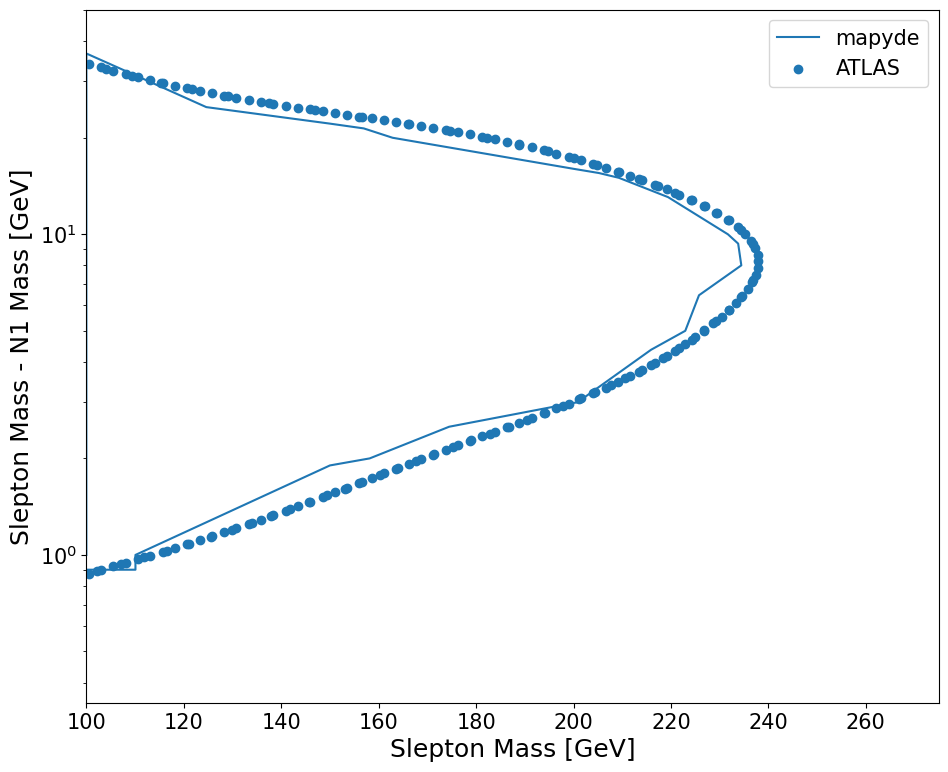

In [17]:
makeplot(result,"expected")

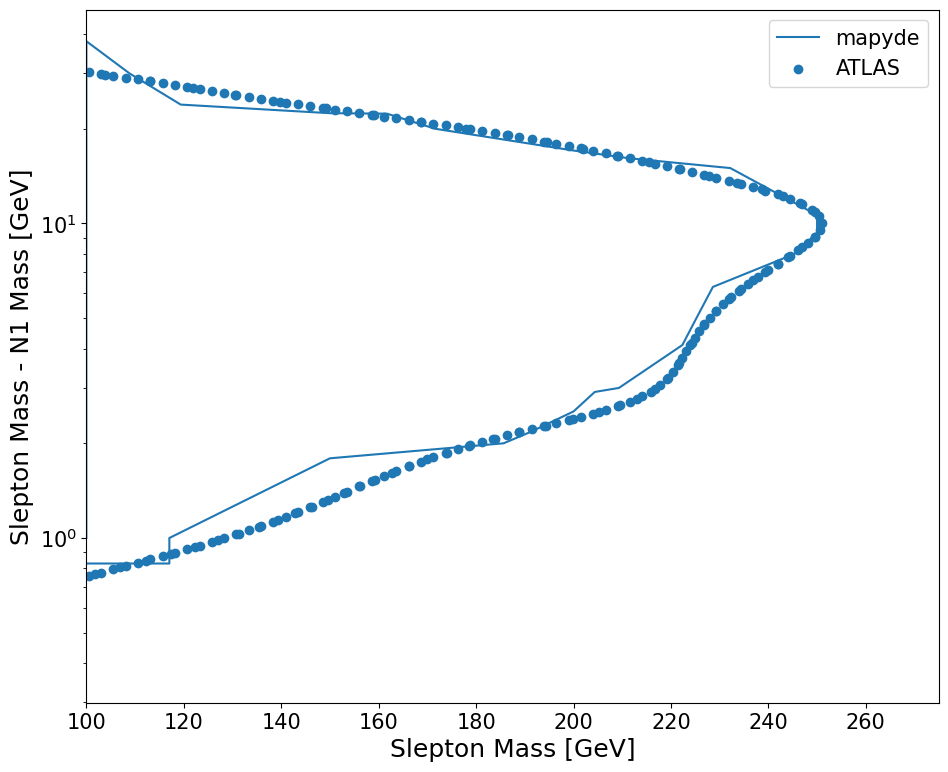

In [50]:
makeplot(result,"observed")

In [51]:
print(json.dumps(create_config(100,99,"SleptonBino"),indent=4))

{
    "base": {
        "path": "/home/jupyter-mhance/mario-mapyde-user/sleptons/SUSY_SleptonBino_isrslep_20220908",
        "output": "SUSY_SleptonBino_isrslep_100_99",
        "logs": "logs",
        "data_path": "/home/jupyter-mhance/.local/share/mapyde",
        "cards_path": "/home/jupyter-mhance/.local/share/mapyde/cards",
        "scripts_path": "/home/jupyter-mhance/.local/share/mapyde/scripts",
        "process_path": "/home/jupyter-mhance/mario-mapyde-user/cards/process/",
        "param_path": "/home/jupyter-mhance/mario-mapyde-user/cards/param/",
        "run_path": "/home/jupyter-mhance/.local/share/mapyde/cards/run/",
        "pythia_path": "/home/jupyter-mhance/.local/share/mapyde/cards/pythia/",
        "delphes_path": "/home/jupyter-mhance/.local/share/mapyde/cards/delphes/",
        "madspin_path": "/home/jupyter-mhance/.local/share/mapyde/cards/madspin/",
        "likelihoods_path": "/home/jupyter-mhance/.local/share/mapyde/likelihoods",
        "template": "/home/ju

## Checking the tuned delphes efficiencies against the defaults

Now do the sleptonbino grid with the default delphes setup so we can see how good/bad the efficiencies are by default.

In [18]:
sleptonbino_defaulteffics_output=[]
for m_slep in [100,150,200,250]:
    for dM in [0.5,1,2,3,5,8,10,15,20,30,50]:
        
        # change the card
        config=create_config(m_slep,m_slep-dM,"SleptonBino")
        config["delphes"]["card"]="delphes_card_ATLAS_lowptleptons_sleptons_notrackineffic.tcl"
        config["base"]["path"]="/home/jupyter-mhance/mario-mapyde-user/sleptons/SUSY_SleptonBino_isrslep_defaulteffics_grid_20230123"
        
        if dask_available:
            # here we load some existing results, in case all we want to do is tweak plots downstream
            sleptonbino_defaulteffics_output.append(dask.delayed(slep_read_results)(m_slep,m_slep-dM,path="sleptons/SUSY_SleptonBino_isrslep_defaulteffics_grid_20230123"))
            # ...or we can just re-run pyhf
            #sleptonbino_defaulteffics_output.append(dask.delayed(slep_run_pyhf)(config=config))
            # ...or we can run the whole thing, generating events from scratch with madgraph
            #sleptonbino_defaulteffics_output.append(dask.delayed(slep_run_all)(config=config))
        else:
            # here we load some existing results, in case all we want to do is tweak plots downstream
            sleptonbino_defaulteffics_output.append(slep_read_results(m_slep,m_slep-dM,path="sleptons/SUSY_SleptonBino_isrslep_defaulteffics_grid_20230123"))
            # ...or we can just re-run pyhf
            #sleptonbino_defaulteffics_output.append(slep_run_pyhf(config=config))
            # ...or we can run the whole thing, generating events from scratch with madgraph
            #sleptonbino_defaulteffics_output.append(slep_run_all(config=config))
             
        
print(len(sleptonbino_defaulteffics_output))

result_defaulteffics=None
# if we're running dask, then the commands above will only schedule things to run, not run them.
if dask_available:
    result_defaulteffics=dask.compute(sleptonbino_defaulteffics_output)
else:
    result_defaulteffics=sleptonbino_defaulteffics_output

44


In [19]:
print(json.dumps(result_defaulteffics[0],indent=4))

[
    {
        "config": {
            "base": {
                "path": "/data/users/mhance/SUSY/SUSY_SleptonBino_isrslep_defaulteffics_grid_20230123",
                "output": "SUSY_SleptonBino_isrslep_100_99.5",
                "logs": "logs",
                "data_path": "/home/mhance/mario-mapyde-user/venv/share/mapyde",
                "cards_path": "/home/mhance/mario-mapyde-user/venv/share/mapyde/cards",
                "scripts_path": "/home/mhance/mario-mapyde-user/venv/share/mapyde/scripts",
                "process_path": "/home/mhance/mario-mapyde-user/venv/share/mapyde/cards/process/",
                "param_path": "/home/mhance/mario-mapyde-user/venv/share/mapyde/cards/param/",
                "run_path": "/home/mhance/mario-mapyde-user/venv/share/mapyde/cards/run/",
                "pythia_path": "/home/mhance/mario-mapyde-user/venv/share/mapyde/cards/pythia/",
                "delphes_path": "/home/mhance/mario-mapyde-user/venv/share/mapyde/cards/delphes/",
         

In [20]:
def makeefficplot(result,result_defaulteffics,limittype):
    
    contour_x,contour_y=makecontour(result,limittype)
    #contours["default"]=makecontour("/data/users/mhance/SUSY/SUSY_SleptonBino_isrslep_defaulteffics_grid_20230123","delphes default",limittype)

    contour_x_de,contour_y_de=makecontour(result_defaulteffics,limittype)
    #contours["default"]=makecontour("/data/users/mhance/SUSY/SUSY_SleptonBino_isrslep_defaulteffics_grid_20230123","delphes default",limittype)

    fig, ax = plt.subplots(figsize=(11,9))
    ax.set_yscale('log')

    contours={}
    colors={}

    ax.plot(contour_x,contour_y,label="mapyde, tuned efficiencies")
    ax.plot(contour_x_de,contour_y_de,label="mapyde, default efficiencies")
    ATcontour=ax.scatter(expected_contour_mass if limittype=="expected" else observed_contour_mass,
                         expected_contour_splitting if limittype=="expected" else observed_contour_splitting,
                         label="ATLAS")

    ax.set_xlabel('Slepton Mass [GeV]',fontsize=18)
    ax.set_ylabel('Slepton Mass - N1 Mass [GeV]',fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlim([100,275])
    ax.legend(loc="upper right",prop={'size': 15})
    #fig.savefig('SleptonBino.pdf')

<Figure size 640x480 with 0 Axes>

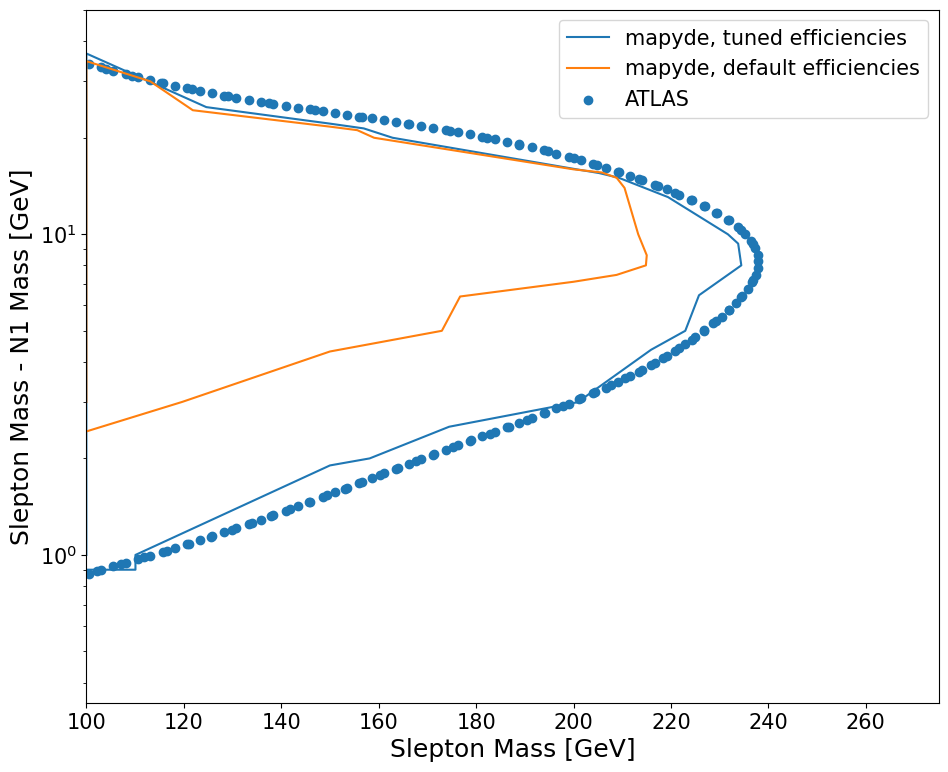

In [21]:
makeefficplot(result,result_defaulteffics,"expected")